# Extract fMRI signal from ROI

In [1]:
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib inline

We now

 * Preprocessed the raw fMRI data: remove low-frequent noise, motion-correction, etc.
 * (Looked a bit at the behavioral data)
 * Registered the functional data to a standard space

Now we are gonna extract signal from an interesting area: the striatum

### A look at masks

In [3]:
!ls /data/masks

GPe_L.nii.gz  GPi_R.nii.gz  SN_L.nii.gz   STh_R.nii.gz
GPe_R.nii.gz  RN_L.nii.gz   SN_R.nii.gz   STR_L.nii.gz
GPi_L.nii.gz  RN_R.nii.gz   STh_L.nii.gz  STR_R.nii.gz


In [4]:
import nipype.interfaces.fsl as fsl

Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
str_l = nb.load('/data/masks/STR_L.nii.gz').get_data()
mni = nb.load(fsl.Info.standard_image('MNI152_T1_2mm_brain.nii.gz')).get_data()

Now we mask teh values of the mask that are zero

In [6]:
str_l = np.ma.masked_equal(str_l, 0)

Let's find the center of mass of the mask

In [7]:
import scipy as sp
from scipy import ndimage
com = ndimage.center_of_mass(str_l)
com

(54.26543316759453, 64.657529033455347, 38.140556408285008)

All the voxels that are masked are not shown

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1298: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=400:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


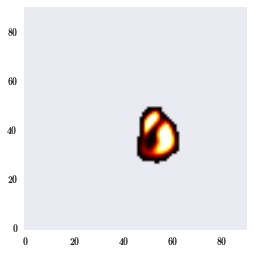

In [8]:
plt.imshow(str_l[:, 64, :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

Now with MNI

/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


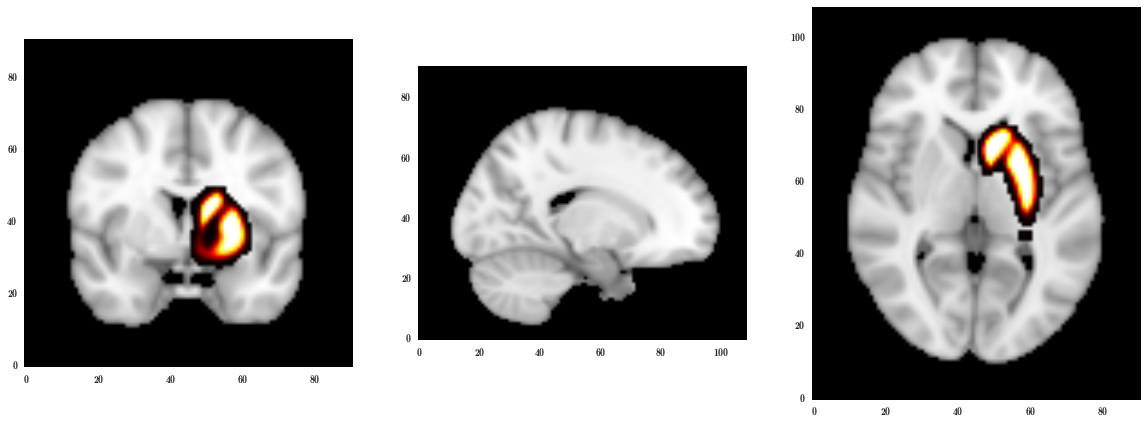

In [9]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(mni[:, 64, :].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[:, 64, :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

plt.subplot(132)
plt.imshow(mni[36, :, :].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[36, :, :].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

plt.subplot(133)
plt.imshow(mni[:, :, 38].T,origin='lower', cmap=plt.cm.gray)
plt.imshow(str_l[:, :, 38].T,origin='lower', cmap=plt.cm.hot)
plt.grid('off')

1) Can you now also plot the right striatum?

### Extracting the signal

2) Now we have the functional preprocessed data in MNI152-space, we can extract the signal from the mask. Fill in the necessary fields to extract the signal in left striatum form block 1 from subject 197.

In [ ]:
extracter = fsl.ImageMeants()
extracter.inputs.in_file = '/data/registration_results/...'
extracter.inputs.mask = '/data/masks/...'


Now we can run the interface, and have a look at its results

In [ ]:
r = extracter.run()
r.outputs

3) Load the data using np.loadtxt() and then plot the raw signal

4) now also extract the signal from right striatum and plot in the same graph. Notice anything?

## Let's pipeline this!

The fsl-interfaces of nipype are nice to quickly have a look at stuff, but if you want to process data systematically, it's good to make a pipeline. You have seen a few before. Let's try to make one ourselves!

In [52]:
import nipype.interfaces.io as nio
import nipype.interfaces.fsl as fsl
import nipype.pipeline.engine as pe

In [53]:
workflow = pe.Workflow(base_dir='/data/workflow_folders/', name='extract_striatum_signal')

Hint: use a asterisk (\*) to "select all files within a directory"

In [55]:
templates = {'mask':'/data/masks/{mask}.nii.gz',
            'func':'/data/registration_results/transformed_files/'}

selector = pe.Node(nio.SelectFiles(templates), name='selector')

selector.iterables = [('subject_id', [...]), ('mask', ['STR_L', 'STR_R'])]

Hint: you probably want to use a [MapNode](http://nipy.sourceforge.net/nipype/users/mapnode_and_iterables.html) here

In [56]:
extracter = ...

In [57]:
ds = pe.Node(nio.DataSink(base_directory='/data/extracted_signals'), name='datasink')

In [58]:
workflow.connect(selector, 'mask', extracter, 'mask')
workflow.connect(selector, 'func', extracter, 'in_file')

workflow.connect(extracter, 'out_file', ds, 'extracted_timeseries')

In [ ]:
workflow.run(plugin='MultiProc', plugin_args={'n_procs' : 3})

5) Plot some of the extracted timeseries in /data/extracted_signals/extracted_timeseries/

## Correlation between brain areas

6) (optional) have a look at sns.corrplot to make correlation plot abo